In [24]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [27]:
daily_total_female_births_in_cal = pd.read_csv('daily-total-female-births-in-cal.csv')['Count']
international_airline_passengers = pd.read_csv('international-airline-passengers.csv')['Count']
mean_mouthly_air_temperature_deg = pd.read_csv('mean-monthly-air-temperature-deg.csv')['Deg']
monthly_boston_armed_robberies_j = pd.read_csv('monthly-boston-armed-robberies-j.csv')['Count']
monthly_sales_of_company_x_jan_6 = pd.read_csv('monthly-sales-of-company-x-jan-6.csv')['Count']
weekly_closings_of_the_dowjones = pd.read_csv('weekly-closings-of-the-dowjones-.csv')['Close']

In [34]:
all_series = {
    "Monthly sales of company X": monthly_sales_of_company_x_jan_6,
    "Monthly Boston armed robberies": monthly_boston_armed_robberies_j,
    "International airline passengers: monthly totals in thousands": international_airline_passengers,
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_mouthly_air_temperature_deg,
    "Weekly closings of the Dow-Jones industrial average": weekly_closings_of_the_dowjones,
    "Daily total female births in California": daily_total_female_births_in_cal
}

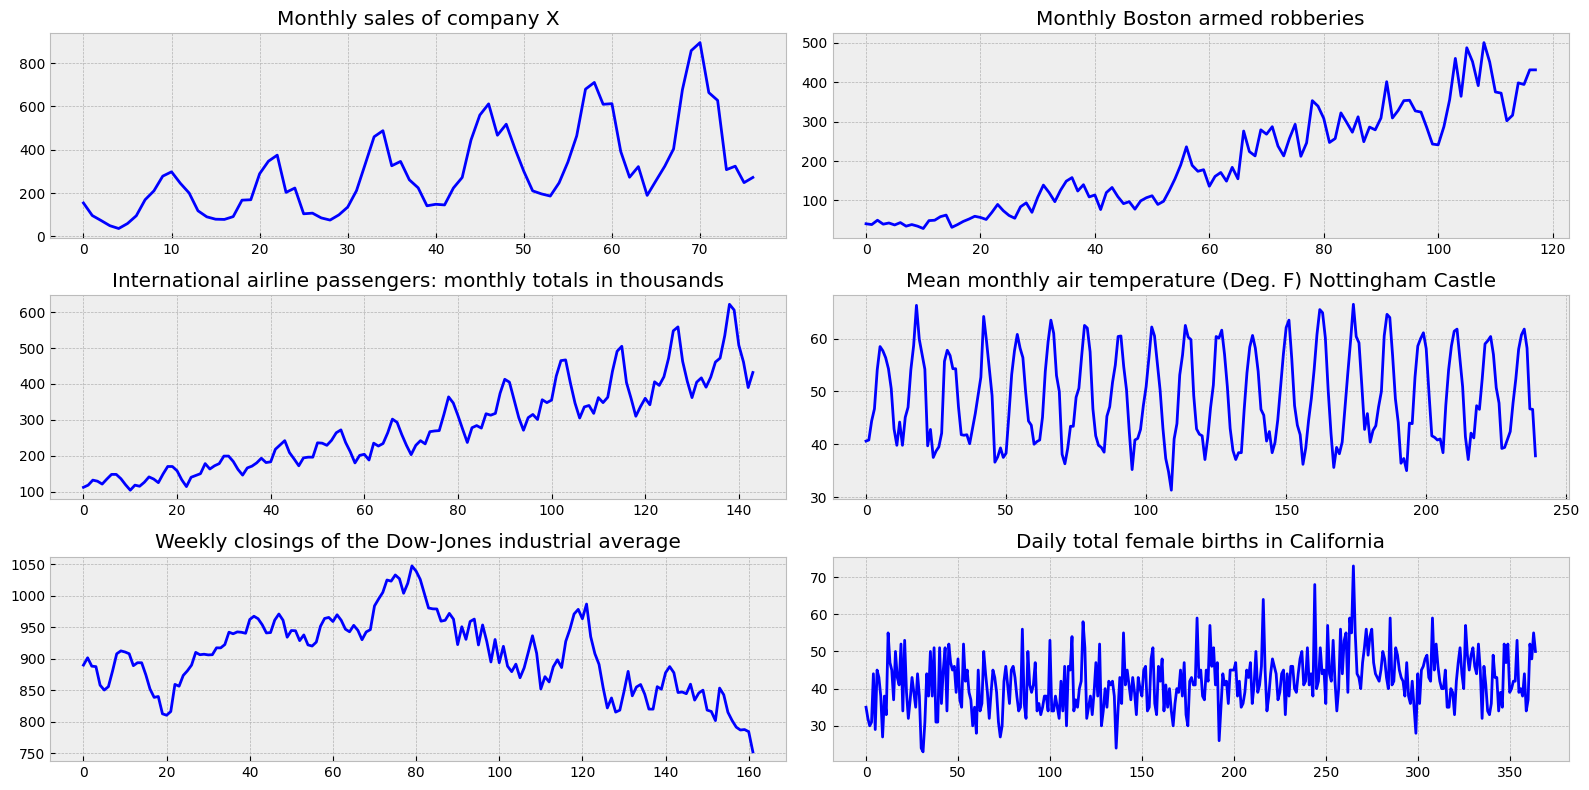

In [35]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)

        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)

    plt.tight_layout()

In [36]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [37]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Выбор стационарного и не стационарного ряда

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


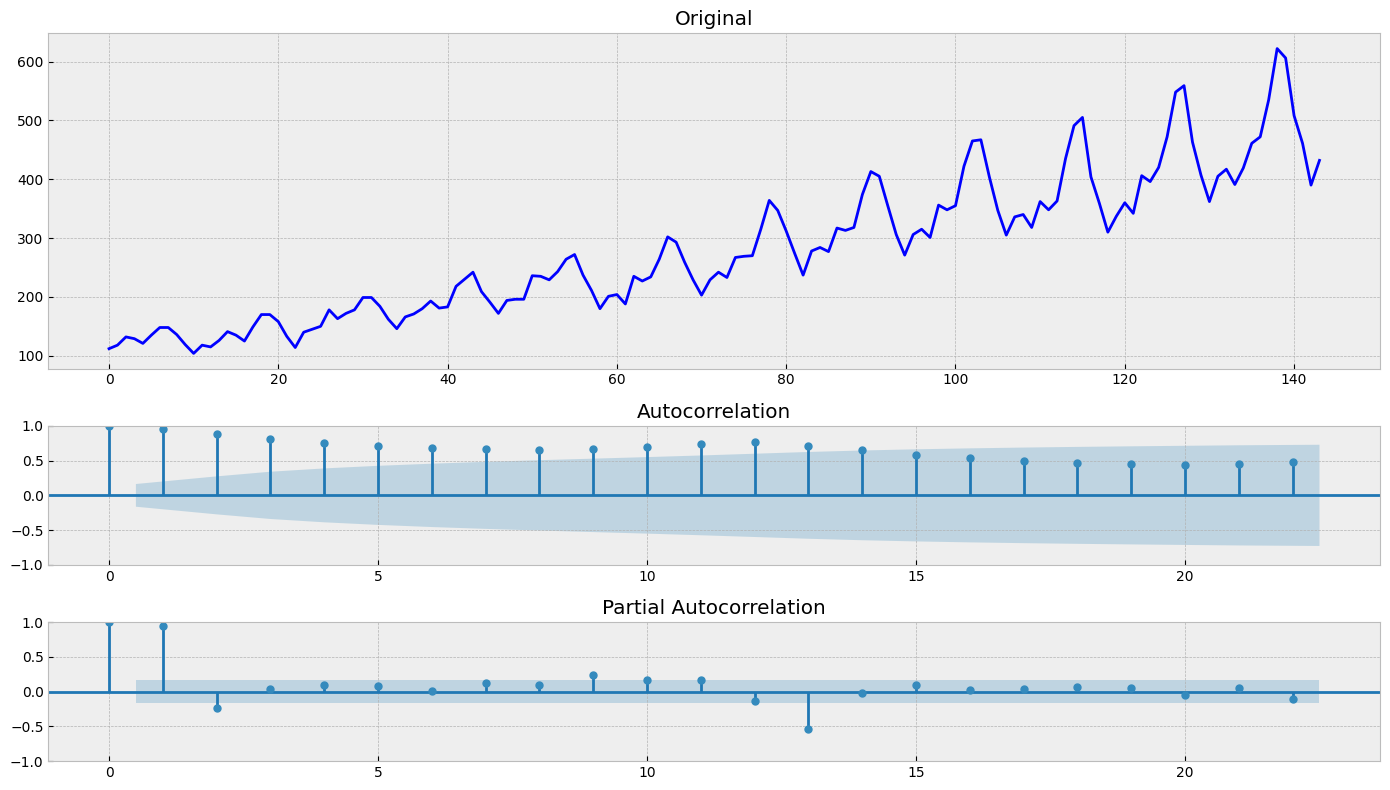

In [38]:
tsplot(international_airline_passengers) # p-value больше 0.05 (0.991880), ряд не стационарен

In [39]:
# уберем изменение дисперсии при помощи преобразования Бокса-Кокса
series = boxcox(international_airline_passengers, 0)

In [40]:
# По графику ряда видно наличие сильного тренда. Уберем его дифференцированием
series = series[1:] - series[:-1]

In [41]:
# по графику коррелограммы видно сильное влияние сезонности. Уберем ее
series = series[12:] - series[:-12]

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


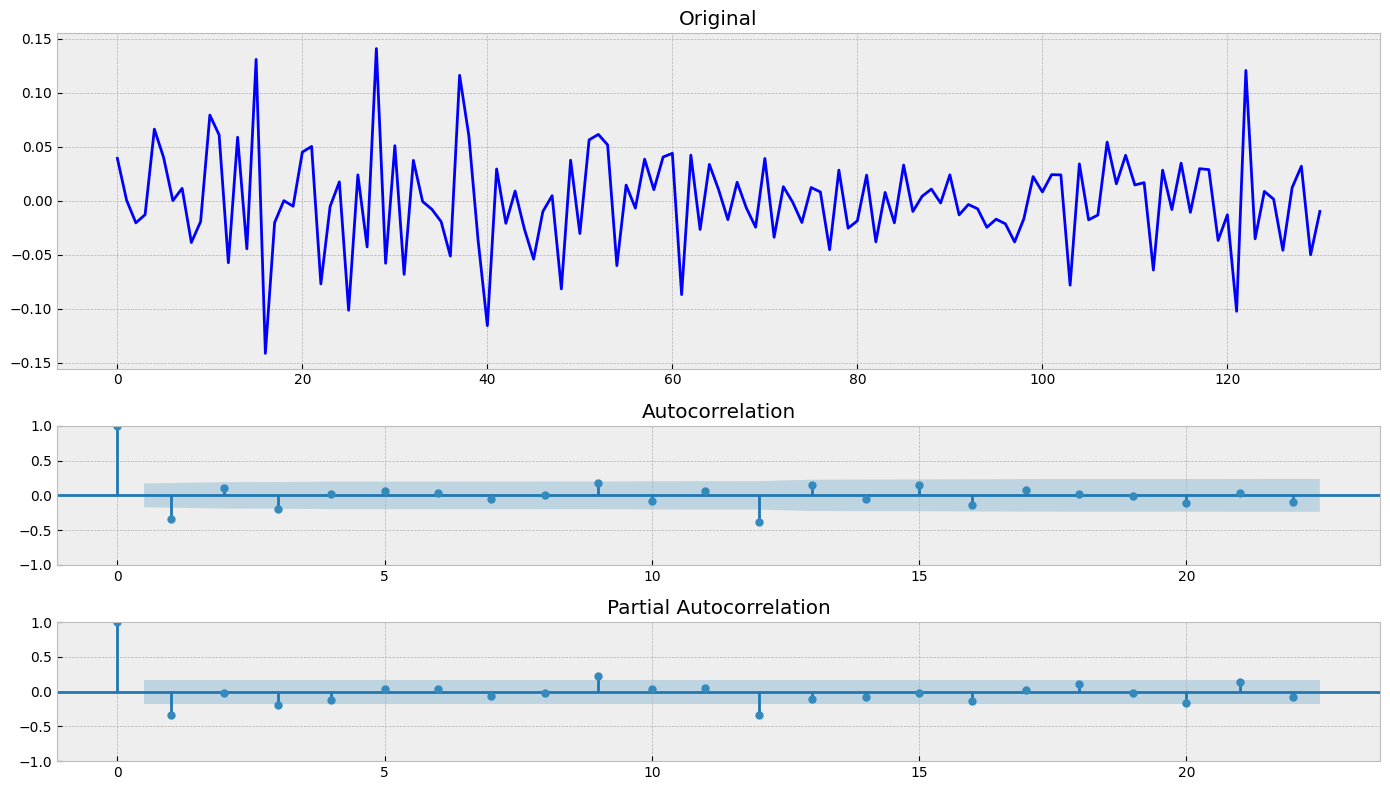

In [42]:
tsplot(series) # p-value меньше 0.05 (0.000249), ряд стационарен

MA

In [43]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [45]:
not_stat = moving_average(international_airline_passengers, 7)

In [49]:
stat = moving_average(series, 7)

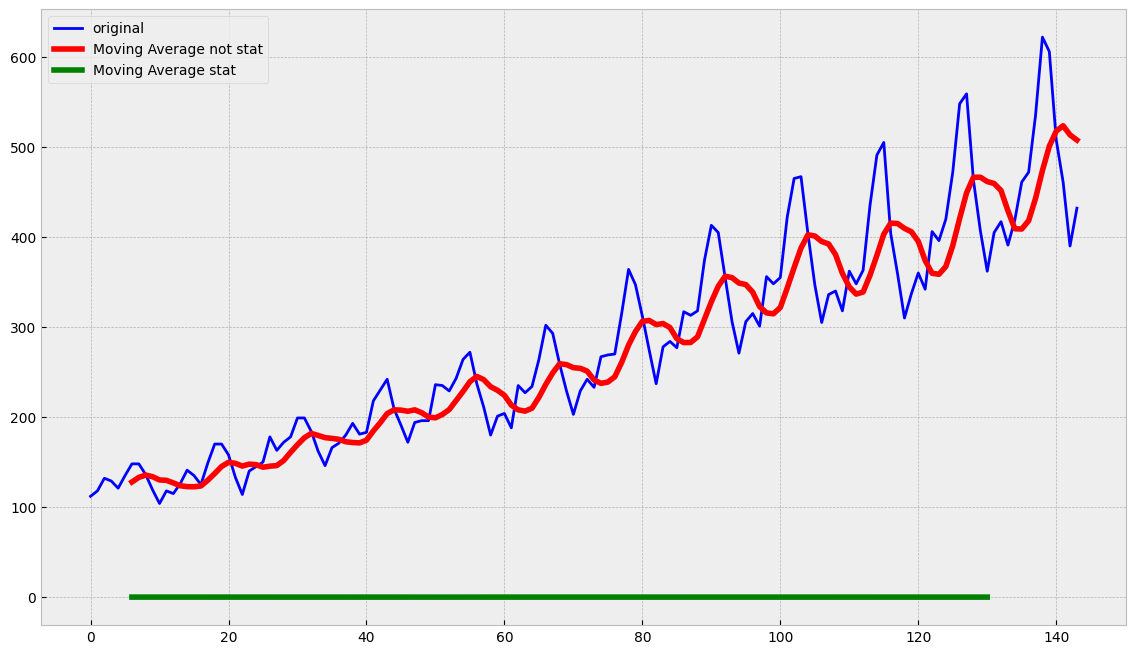

In [50]:
not_stat = moving_average(international_airline_passengers, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(international_airline_passengers, color='blue',label='original')
    plt.plot(not_stat, color='red', linewidth='4', label='Moving Average not stat')
    plt.plot(stat, color = 'green', linewidth='4', label='Moving Average stat')
    plt.legend()

WMA

In [57]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

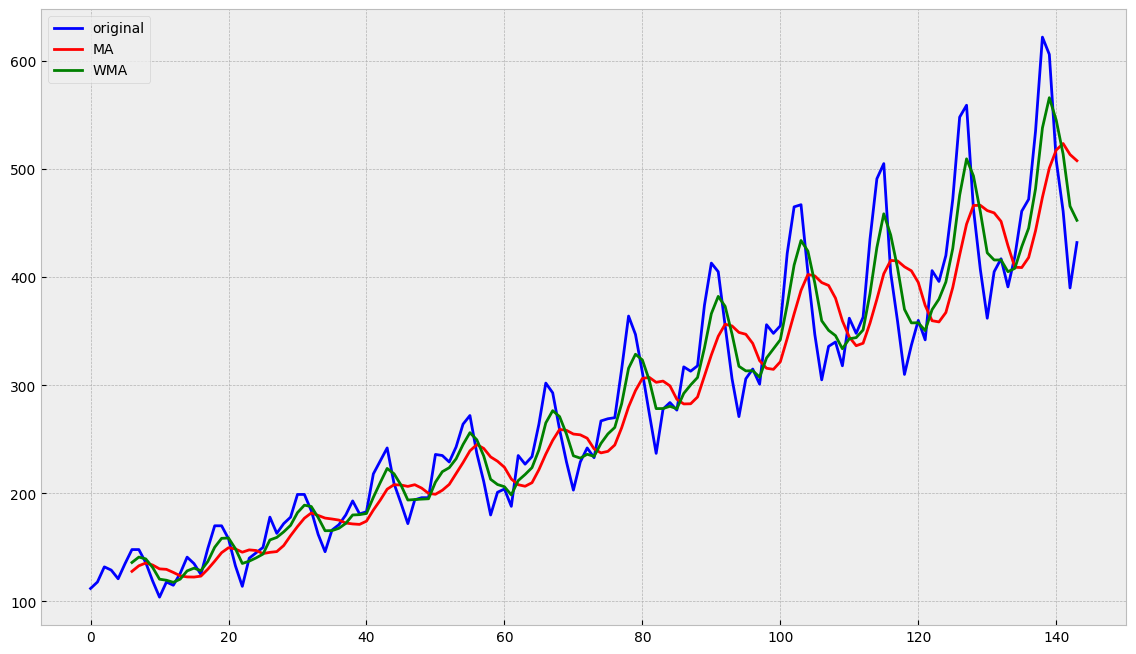

In [63]:
wma = weighted_moving_average(international_airline_passengers, 7, [1,1,2,3,5,8,13]) # для не стационарного ряда
ma = moving_average(international_airline_passengers, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(international_airline_passengers, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

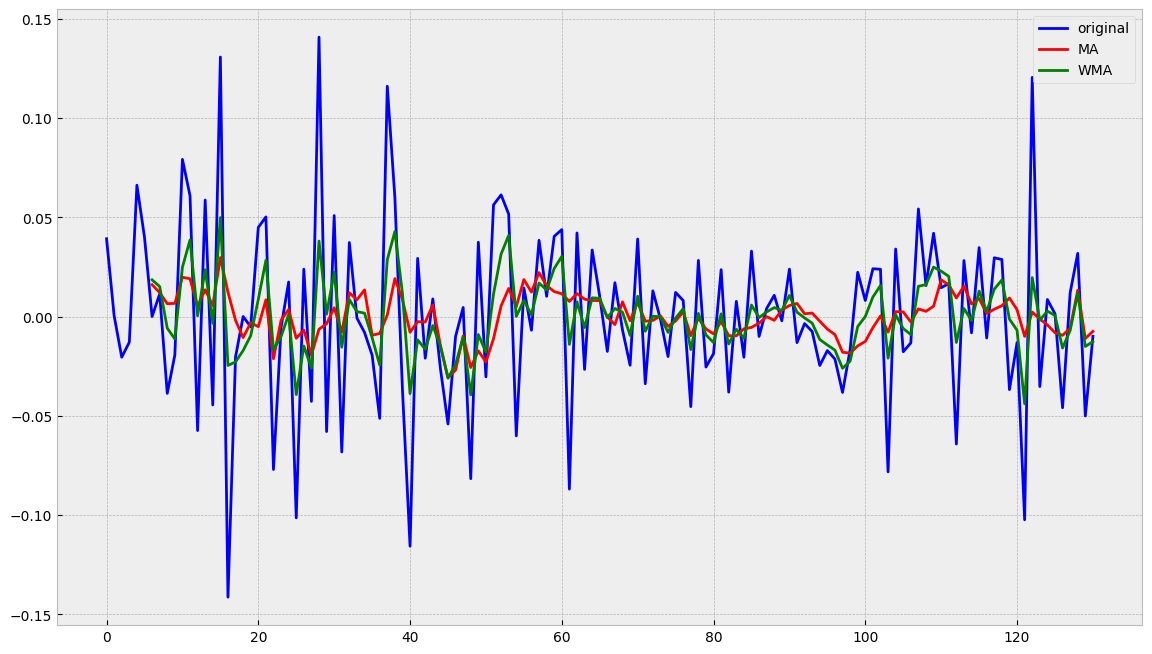

In [64]:
wma = weighted_moving_average(series, 7, [1,1,2,3,5,8,13]) # для стационарного ряда
ma = moving_average(series, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.legend()

EMA

In [59]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [60]:
ema = exponential_moving_average(international_airline_passengers, 0.2)

In [61]:
len(ema)

144

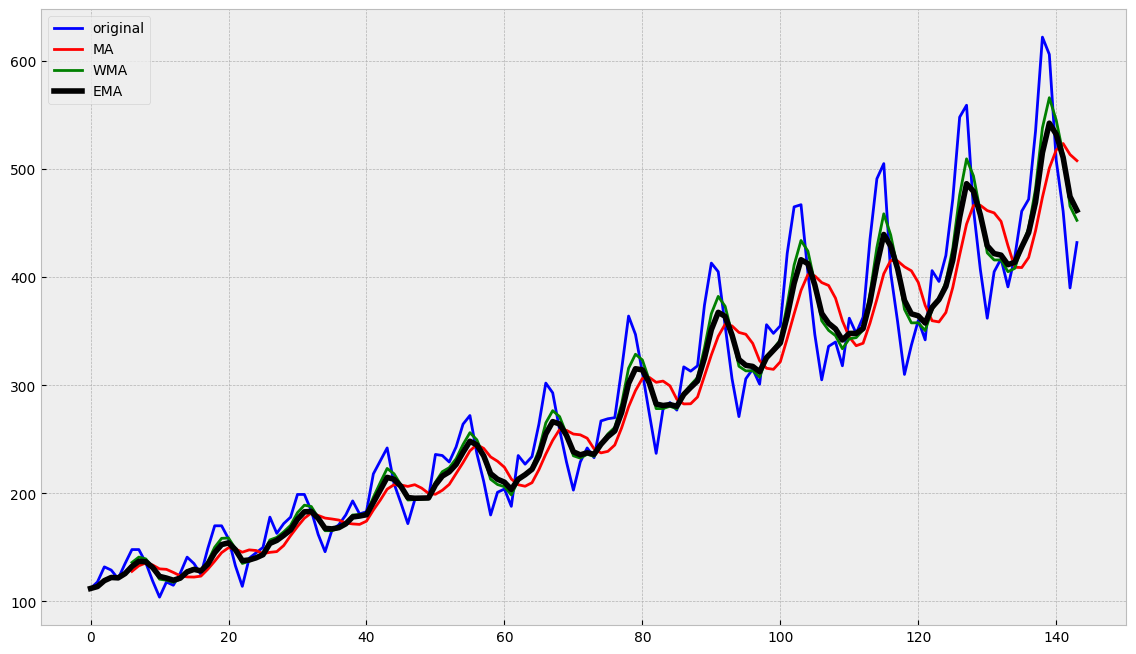

In [65]:
ema = exponential_moving_average(international_airline_passengers, 0.3) # для не стационарного ряда
wma = weighted_moving_average(international_airline_passengers, 7, [1,1,2,3,5,8,13])
ma = moving_average(international_airline_passengers, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(international_airline_passengers, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

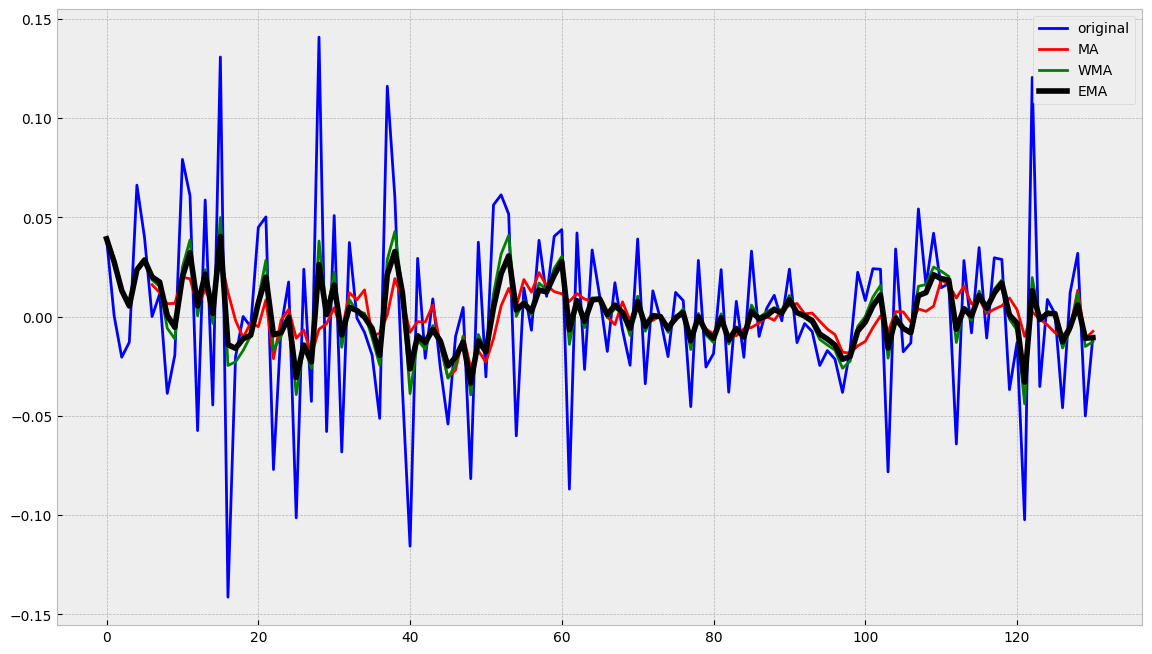

In [66]:
ema = exponential_moving_average(series, 0.3) # для стационарного ряда
wma = weighted_moving_average(series, 7, [1,1,2,3,5,8,13])
ma = moving_average(series, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series, color='blue',label='original')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='4', label='EMA')
    plt.legend()

DEMA

In [67]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [69]:
def plot_dema(alpha, beta): # для не стационарного ряда
    dema = double_ema(international_airline_passengers, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(international_airline_passengers, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

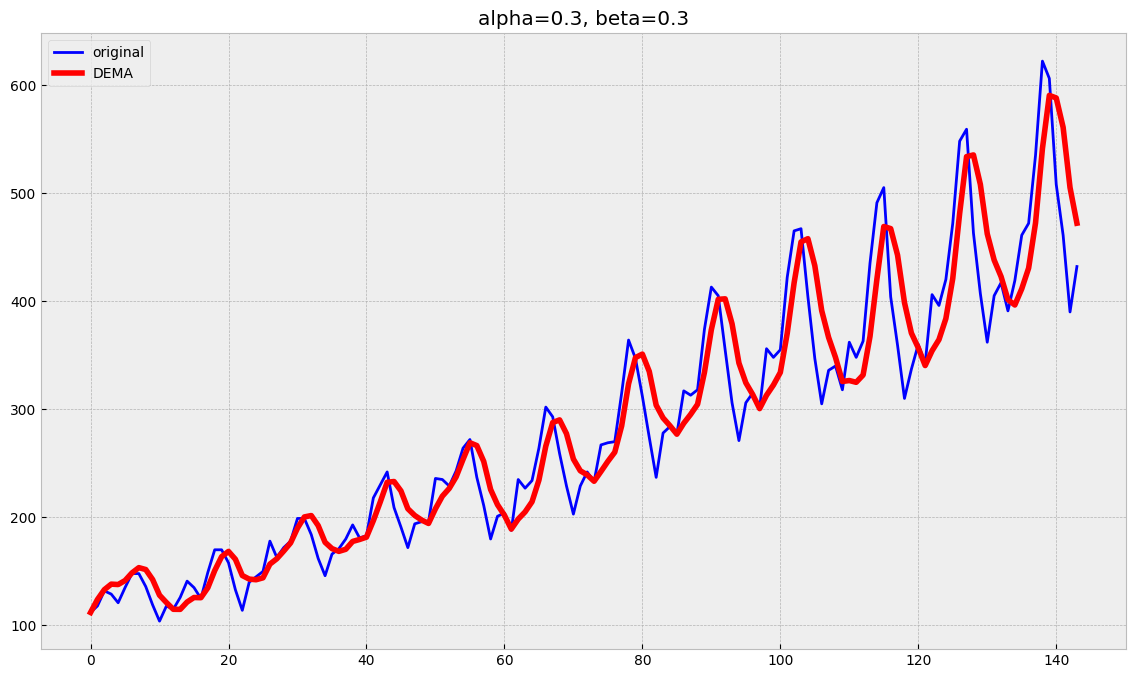

In [75]:
plot_dema(0.3, 0.3)

In [76]:
def plot_dema_st(alpha, beta): # для стационарного ряда
    dema = double_ema(series, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

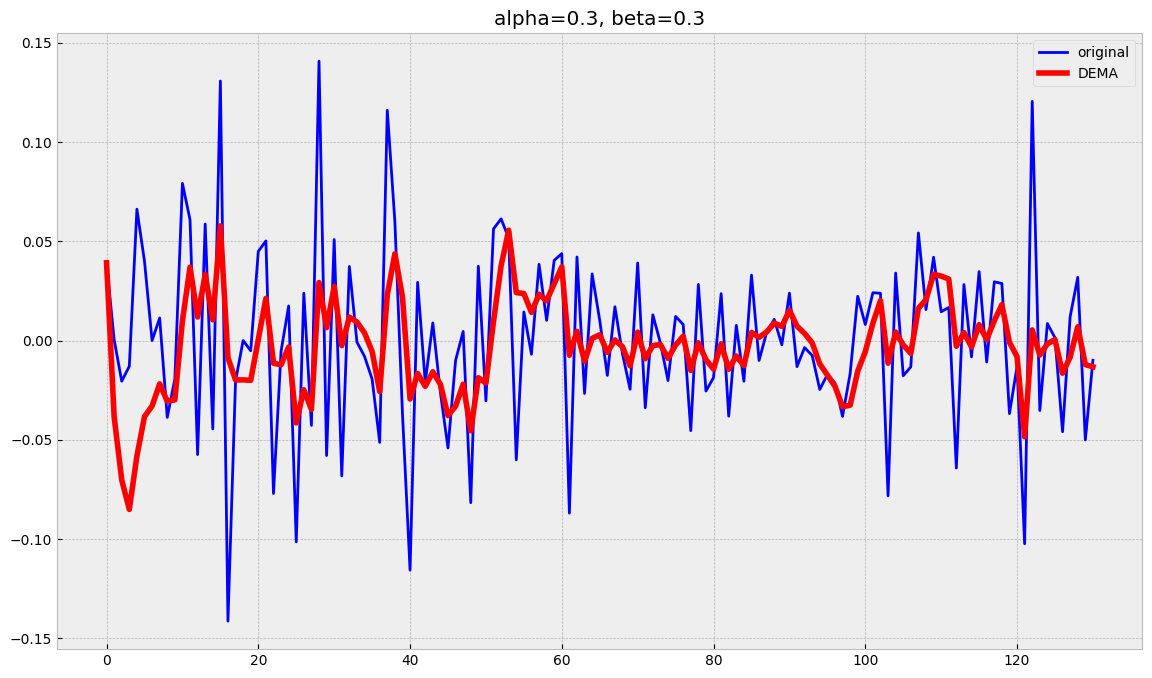

In [77]:
plot_dema_st(0.3, 0.3)

TEMA

In [78]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [79]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [80]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [82]:
def plot_tema(alpha, beta, gamma, ser=international_airline_passengers, ser_to_plot=international_airline_passengers, n_preds=24): #для не стационарного ряда
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

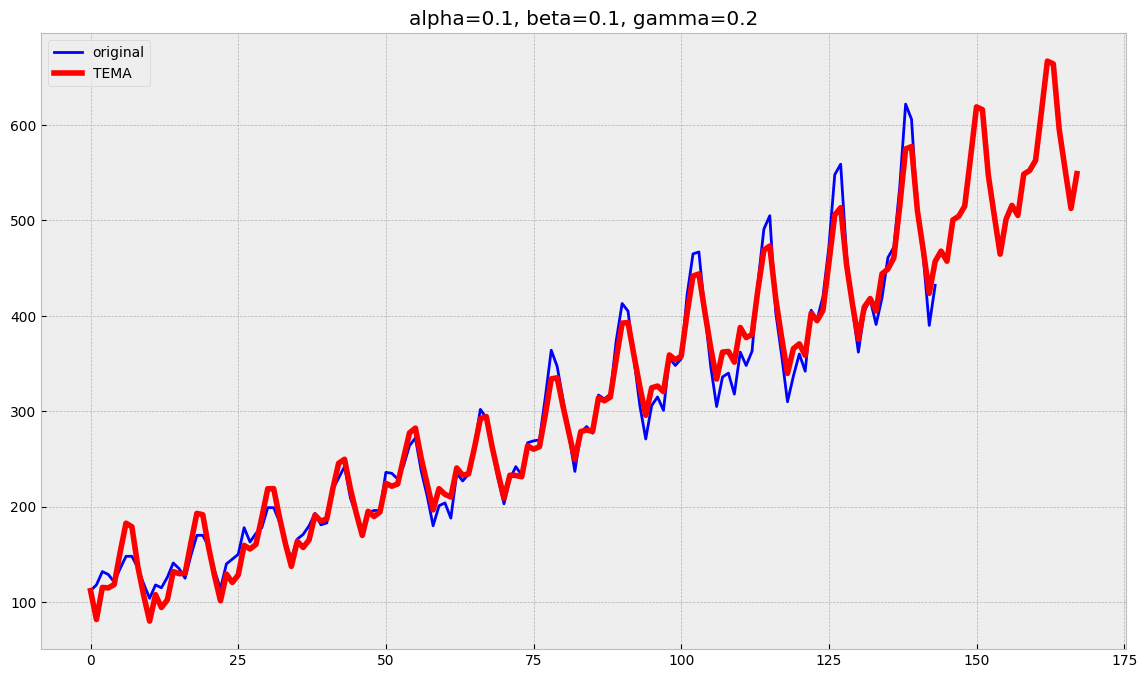

In [83]:
plot_tema(0.1, 0.1, 0.2)

In [84]:
def plot_tema(alpha, beta, gamma, ser=series, ser_to_plot=series, n_preds=24): #для стационарного ряда
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

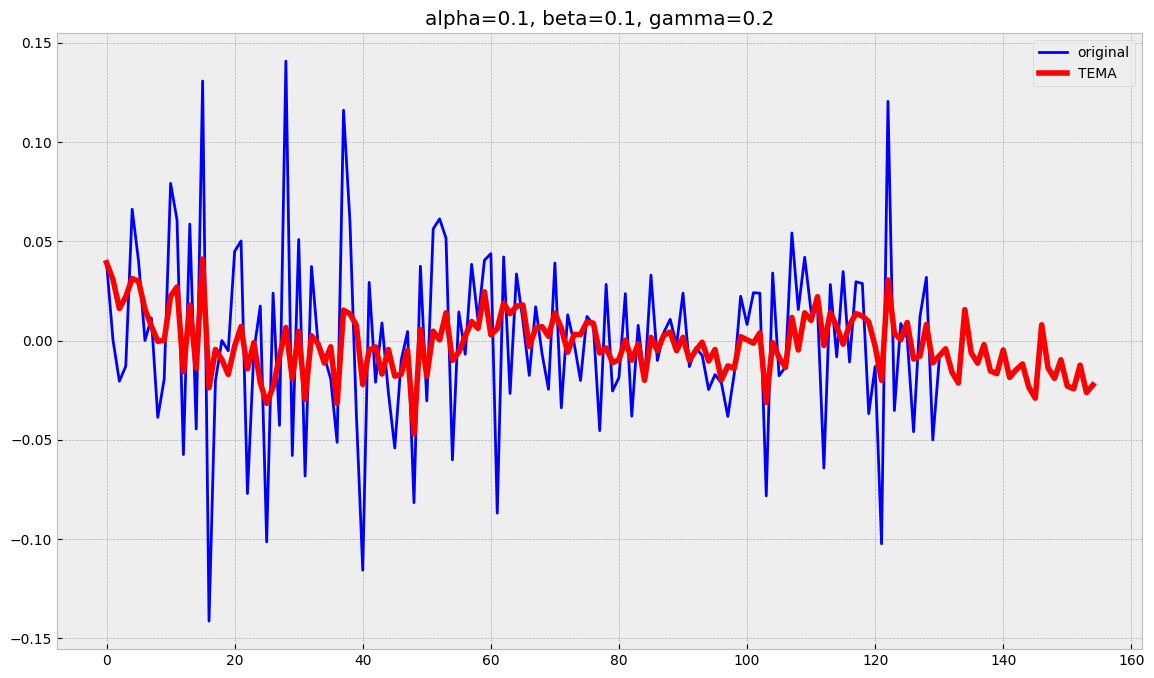

In [85]:
plot_tema(0.1, 0.1, 0.2)

Для временного ряда international_airline_passengers больше всего подходит TEMA. Временной ряд обладает всеми свойствами и данный метод обрабатывает все, что дает наиболее точный результат  